# Load data

### Purpose

In this notebook, we want to browse some of the datasets that we have loaded in a simple way.

In [27]:
%pylab inline
plt.style.use("default")
import os, sys
from scipy.io import loadmat
from glob import glob

Populating the interactive namespace from numpy and matplotlib


In [164]:
def pad_vector(v, desired_length, pad_with = np.nan):
    v_new = np.zeros((desired_length,))
    v_new[:len(v)] = v
    v_new[len(v):] = pad_with
    return v_new

In [165]:
def abib_cdf(r, r_min = -np.inf, **kwargs):
    r_kept = r[r>r_min]
    print(f"Dropped {len(r) - len(r_kept)} values less than {r_min=}")
    x = sorted(r_kept)
    y = arange(1, len(r_kept)+1)/(len(r_kept))
    plot(x,y, **kwargs)
    return r_kept

In [2]:
data_root = "/Users/stootoon/data/robust-signatures/stringer2019"

In [3]:
data_files = [fname.split("/")[-1] for fname in glob("/Users/stootoon/data/robust-signatures/stringer2019/*")]
data_files

['images_natimg2800_all.mat',
 'natimg2800_M160825_MP027_2016-12-14.mat',
 'natimg2800_8D_M170717_MP033_2017-08-22.mat']

In [9]:
data = loadmat(os.path.join(data_root, data_files[1])
               ,simplify_cells = True) 

In [ ]:
def load_stringer_data():
    pass

In [10]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'db', 'med', 'stat', 'stim'])

# Plot ROIs using data.med

In [18]:
from mpl_toolkits import mplot3d

Text(0.5, 0, 'z')

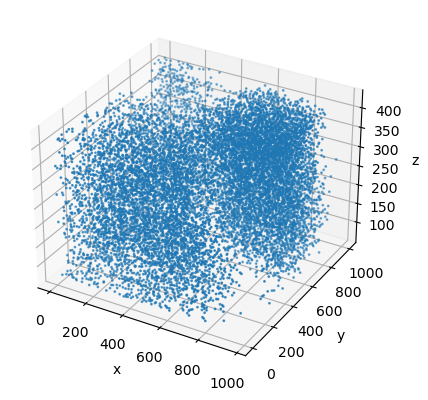

In [28]:
fig = figure()
ax = axes(projection='3d')
x, y, z = data["med"].T
ax.scatter(x,y,z, s=1)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

# data.stat

In [32]:
data["stat"][0].keys()

dict_keys(['ipix', 'ypix', 'xpix', 'lam', 'lambda', 'npix', 'med', 'neuropilCoefficient', 'baseline', 'footprint', 'mrs', 'mrs0', 'cmpct', 'aspect_ratio', 'ellipse', 'mimgProj', 'mimgProjAbs', 'isoverlap', 'radius', 'ipix_neuropil', 'dFstat', 'skew', 'std', 'maxMinusMed', 'top5pcMinusMed', 'blockstarts', 'iplane', 'iscell', 'noiseLevel'])

We can probably ignore this for now.

# data.stim

In [36]:
data["stim"].keys()

dict_keys(['spont', 'resp', 'istim'])

In [35]:
data["stim"]["spont"].shape

(4696, 11449)

In [37]:
data["stim"]["resp"].shape

(5426, 11449)

In [38]:
data["stim"]["istim"].shape

(5426,)

In [39]:
print(f"Number of unique stimuli presented: {len(unique(data['stim']['istim']))}")

Number of unique stimuli presented: 2801


# Let's look at some responses

In [41]:
X = data["stim"]["resp"]
X.shape

(5426, 11449)

Text(0.5, 1.0, 'ROI responses to images')

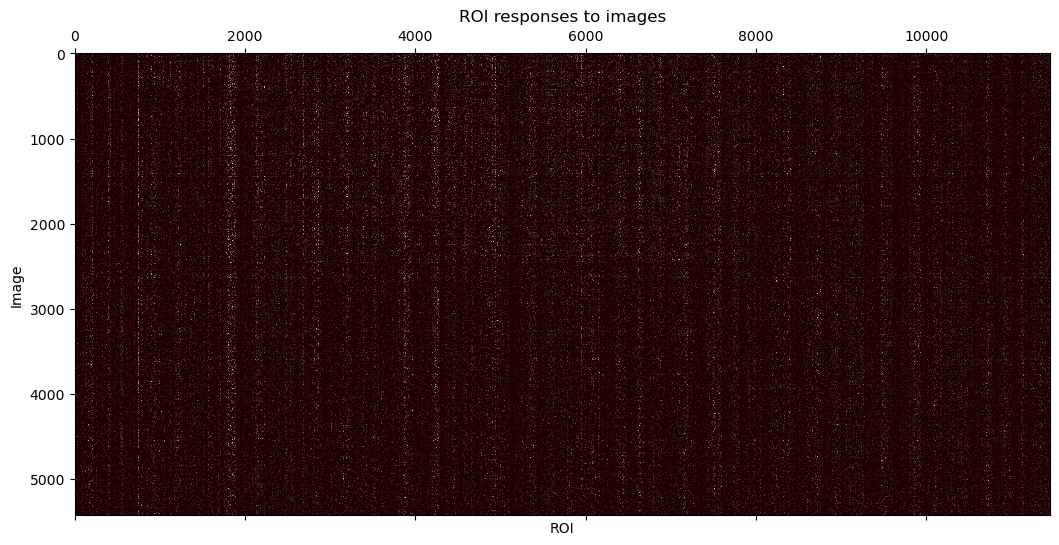

In [51]:
figure(figsize=(14,6))
matshow(X, cmap = cm.pink, fignum=False)
xlabel("ROI")
ylabel("Image")
title("ROI responses to images")

# What is the overall distribution of responses

In [55]:
n_bins = int(sqrt(len(Xall)))

In [69]:
Xall = X.flatten();
Xall[Xall<=0] = 1e-8

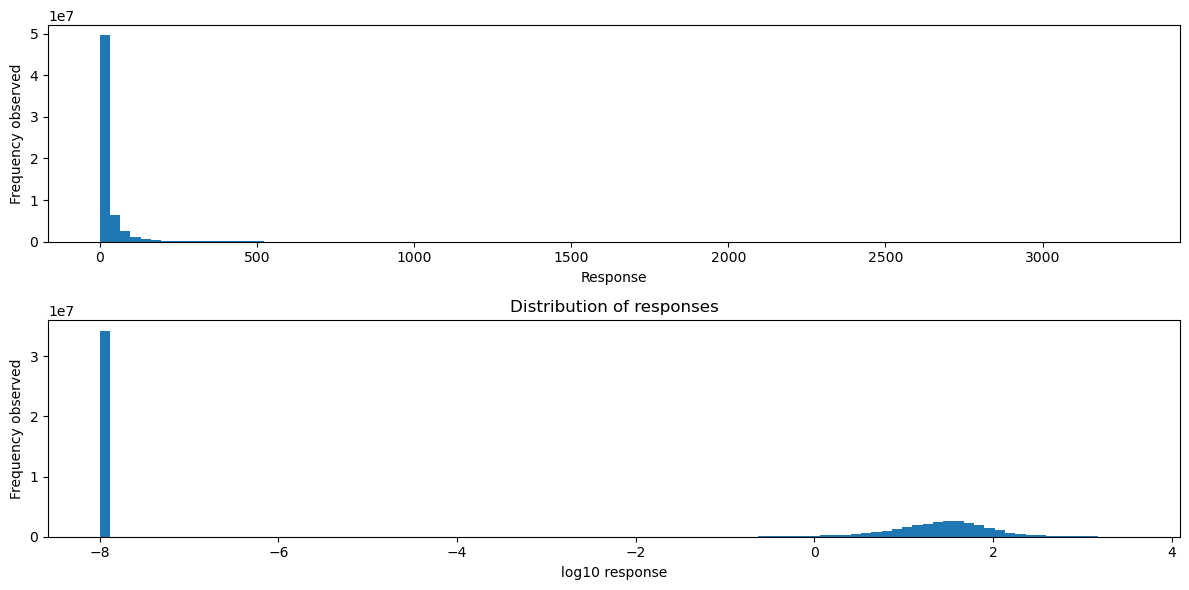

In [73]:
figure(figsize=(12,6))
subplot(2,1,1)
hist(Xall, bins = 100);
xlabel("Response"); ylabel("Frequency observed")
subplot(2,1,2)
hist(log10(Xall), bins = 100);
xlabel("log10 response"); ylabel("Frequency observed")
title("Distribution of responses")
tight_layout()

Dropped 4407 values less than r_min=-2
Dropped 0 values less than r_min=-inf


<ipython-input-130-300134cb506e>:9: RuntimeWarning: divide by zero encountered in log10
  r_kept = abib_cdf(log10(X[0]),r_min=-2);


array([2.01489815, 1.35552655, 1.57509184, ..., 1.7800444 , 0.67222081,
       1.60176057])

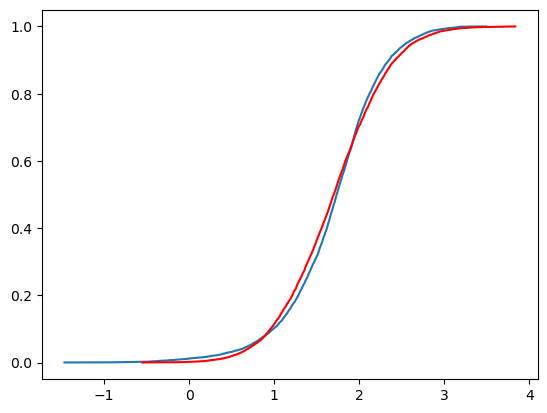

In [130]:


r_kept = abib_cdf(log10(X[0]),r_min=-2);
gauss_data = randn(10000,)* std(r_kept) + mean(r_kept)
abib_cdf(gauss_data, c="r")



Gaussian data should have skewness of 0. Our data seems to be skewed.

In [132]:
from scipy.stats import skew, kurtosis

In [134]:
skew(gauss_data), skew(r_kept)

(0.002916140674799112, -0.6458167496423826)

### Exercise for Abib: Fit Gamma distribution, skewed gaussian

# Plot distribution of responses / neuron

In [75]:
from matplotlib.gridspec import GridSpec

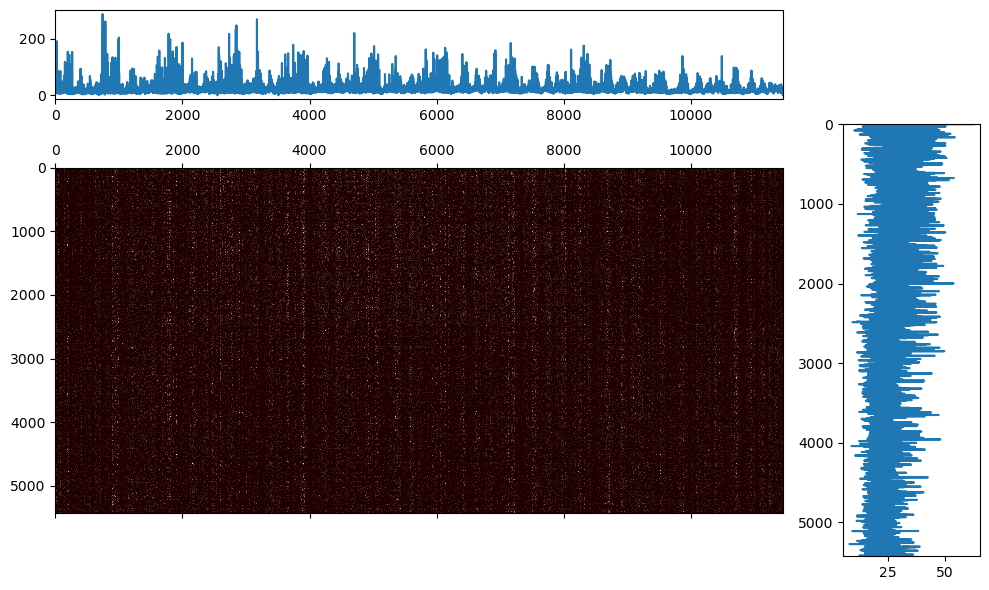

In [93]:
figure(figsize=(10,6))
gs = GridSpec(5,5)
ax_data = subplot(gs[1:,:-1])
matshow(X, cmap=cm.pink, fignum=False)
ax_roi  = subplot(gs[0, :-1], sharex=ax_data)
ax_roi.plot(mean(X,axis=0))
ax_stim = subplot(gs[1:,-1],  sharey = ax_data)
xvals = mean(X,axis=1);
yvals = arange(X.shape[0]);
ax_stim.plot(xvals, yvals)
tight_layout();

# Is there a relation between responses and location

We notice that some neurons respond more to images than others. Why?
Is this due to location?

In [95]:
# locations
x, y, z = data["med"].T
r = np.mean(X,axis=0)

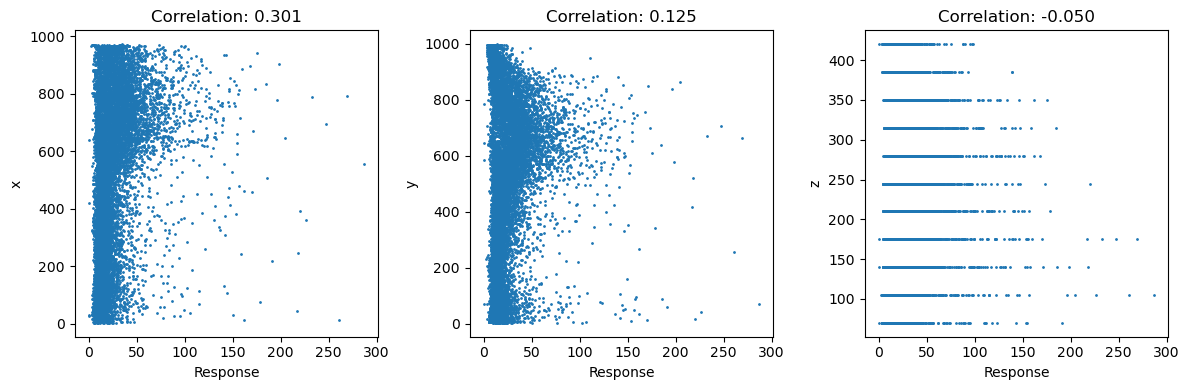

In [101]:
figure(figsize=(12,4))
for i, (name,v) in enumerate(zip("xyz",[x,y,z])):
    subplot(1,3,i+1)
    scatter(r, v, s=1)
    c = corrcoef(r,v)[0,1]
    ylabel(name); xlabel("Response")
    title(f"Correlation: {c:1.3f}")
tight_layout()

# Let's regress responses on X,Y position

In [102]:
from sklearn.linear_model import LinearRegression

In [119]:
lr = LinearRegression()
Xin = np.array([x,y,z]).T
r_pred = lr.fit(Xin, r).predict(Xin)

Text(0.5, 1.0, 'Correlation: 0.319')

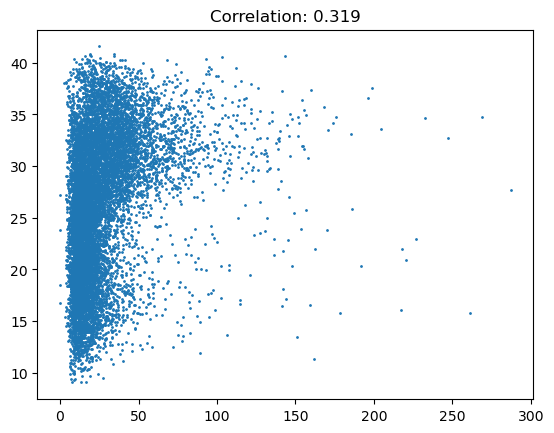

In [120]:
scatter(r, r_pred, s=1);
c = corrcoef(r, r_pred)[0,1]
title(f"Correlation: {c:1.3f}")

# What do the individual neural responses look like?

Text(0, 0.5, 'Images')

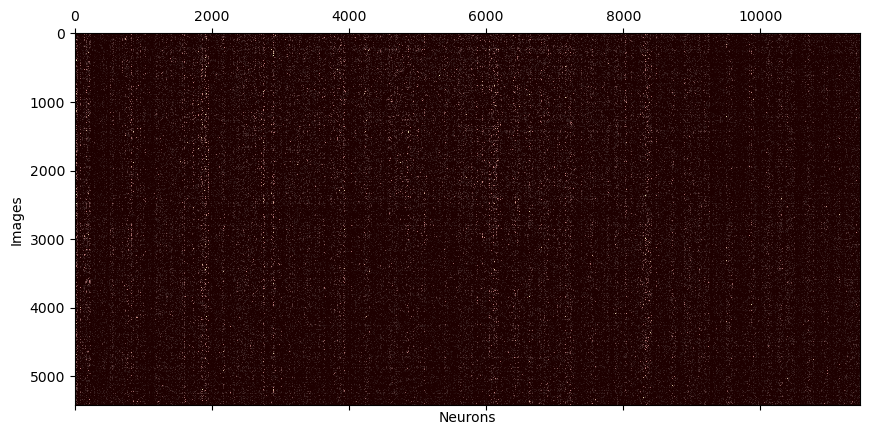

In [136]:
matshow(X, cmap=cm.pink); xlabel("Neurons"); ylabel("Images")

# Abib's question: what do the responses of the most active neuron look like.

In [139]:
n_images, n_neurons = X.shape

In [149]:
r = mean(X, axis=0)

In [150]:
assert len(r) == n_neurons, f"Expected {n_neurons} values, got {len(r)}."

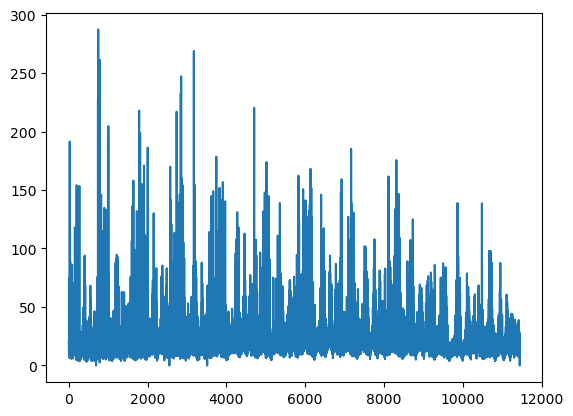

In [151]:
plot(r) 

In [153]:
imax = argmax(r)

In [154]:
Xmax = X[:, imax]

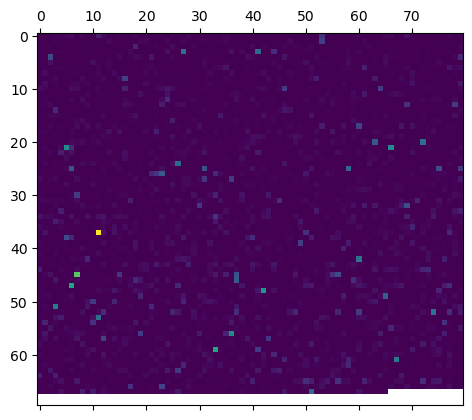

In [169]:
matshow(pad_vector(Xmax, 5600).reshape(70,80))

# Normalize the data

In [173]:
Xstd = std(X,axis=0)
Xvar = var(X,axis=0)

In [172]:
Xm = mean(X,axis=0)

Text(0, 0.5, 'Variance of neuron response')

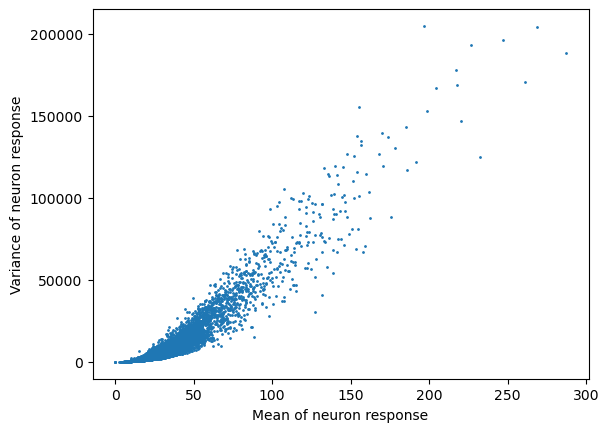

In [175]:
scatter(Xm, Xvar,s=1)
xlabel("Mean of neuron response")
ylabel("Variance of neuron response")

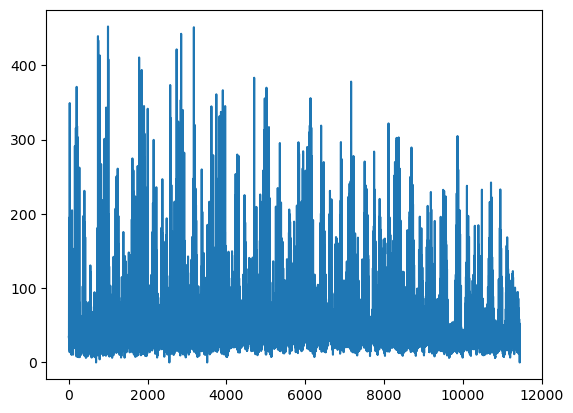

In [171]:
plot(Xstd)

In [176]:
X.shape

(5426, 11449)

In [179]:
Z = X / (Xstd + 1e-12)

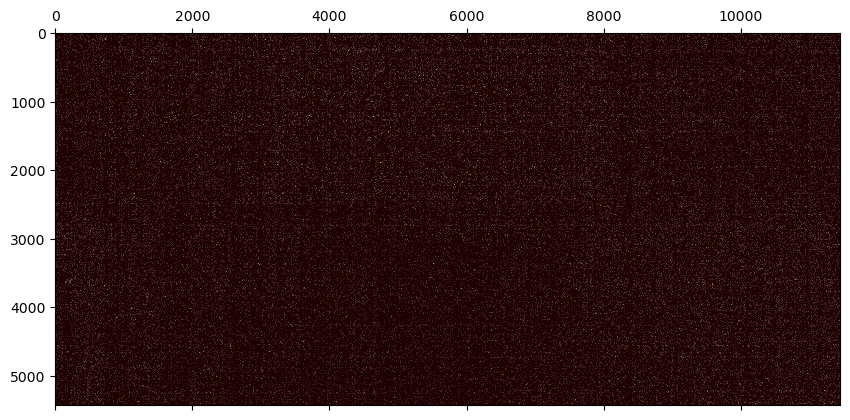

In [180]:
matshow(Z, cmap=cm.pink)

In [183]:
im_order = argsort(Z[:,imax])

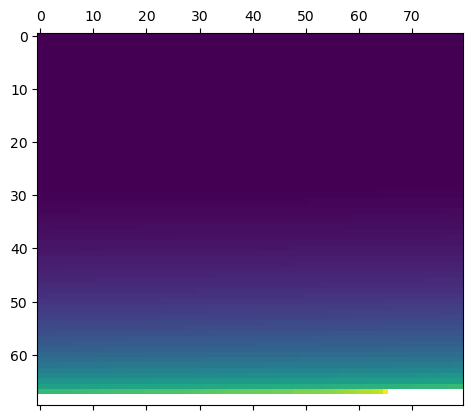

In [188]:
matshow(pad_vector(Z[im_order,imax], 5600).reshape(70,80))